In [37]:
import numpy as np
from PIL import Image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.filters.edges import convolve
import copy
import random
import math

# dimensions to save the image in pixels
x_size = 400 #1920 #
y_size = 225 #1080 #
scale_ratio = 0.22 #(x_size*100/1920)/100

videos = ['MVI_0788_VIS_OB', 'MVI_0789_VIS_OB', 'MVI_0792_VIS_OB', 'MVI_0794_VIS_OB', 'MVI_0796_VIS_OB', 'MVI_0804_VIS_OB']

In [46]:
video = videos[5]

# Read GT data
data = loadmat("../../../../Dataset/VIS_Onboard/HorizonGT/" + video + "_HorizonGT")
frame_number = 298
# Get the number of frames
#frames_number = len(data['structXML'][0])

horizon = data['structXML'][0][frame_number]
px = horizon[0][0][0]*scale_ratio
py = horizon[1][0][0]*scale_ratio
m = horizon[2][0][0]/horizon[3][0][0]

print(px)
print(py)
print(math.acos(horizon[3][0][0]))

211.31
102.93924505190033
0.004952839687412285


In [2]:
class LeastSquares(object):
    def __init__(self, mu, bias_mu):
        self.points = []
        self.w = [0, 0]
        self.mu = mu
        self.bias_mu = bias_mu
        
    def addPoint(self, point):
        self.points.append(point)        
        
    def setPoints(self, points):
        self.points = points
        
    def steps(self, n):
        for i in range(n):
            self.step()
        
    def step(self):      
        w = self.w
        
        grad = 0
        for p in self.points:
            grad += p[0] * (( (w[0] * p[0]) + w[1]) - p[1] ) 
        grad*=2
        #print(grad)
        w[0] -= (grad * self.mu)
        
        grad = 0
        for p in self.points:
            grad += 1 * (( (w[0] * p[0]) + w[1]) - p[1] )
        grad*=2
        #print(grad)
        w[1] -= (grad * self.bias_mu)            
        
    def error(self):
        e = 0
        for p in self.points:
            e += (p[1] - ((p[0] * self.w[0]) + self.w[1] ))**2
        e /= 2
        return e / len(self.points)

    def printParams(self):
        print("w: %s" % str(self.w))

    def draw(self):
        stroke(0,0,0)
        fill(255,0,0)
        for p in self.points:
            x, y = p
            circle(x, y, 6)
        
        for i in range(400):
            y = i * self.w[0] + self.w[1]
            point(i, y)   
            
class LinearRANSAC(object):
    def __init__(self, t, d, mu, bias_mu):
        self.points = []
        self.pointPool = []
        self.t = t
        self.d = d
        self.mu = mu
        self.bias_mu = bias_mu
        self.lastMaybeModel = None
        self.lastMaybeInliers = None
        self.lastAlsoInliers = None
        self.bestModel = None
        self.bestErr = float("inf")
    
    def nextPoints(self):
        if len(self.pointPool) >= 2:
            random.shuffle(self.pointPool)
            p = self.pointPool[:2]
            self.pointPool = self.pointPool[2:]
            return p
        else:
            return None
        
    def error(self):
        return self.bestErr
    
    def errorPt(self, m, p):
        return (p[1] - ((p[0] * m[0]) + m[1] ))**2
    
    def linearModel(self, p1, p2):
        d = (p1[0] - p2[0]) if p1[0] - p2[0] != 0 else 0.01
        m = (p1[1] - p2[1]) / d
        b = p1[1] - (m * p1[0])
        #print("2-point model: %s" % str([m,b]))
        return [m, b]
    
    def addPoint(self, point):
        self.points.append(point)
        self.pointPool = copy.copy(self.points)
    
    def step(self):
        maybeInliers = self.nextPoints()
        self.lastMaybeInliers = maybeInliers
        #print("points selected: %s" % (maybeInliers))
        alsoInliers = []
        
        if maybeInliers:
            maybeModel = self.linearModel(maybeInliers[0], maybeInliers[1])
            self.lastMaybeModel = maybeModel
            for p in self.points:
                if self.errorPt(maybeModel, p) <= self.t:
                    alsoInliers.append(p)
                    
            self.lastAlsoInliers = alsoInliers
                    
            #print("alsoInliers: %d" % len(alsoInliers))
            if len(alsoInliers)-2 >= self.d:
                #print("found viable model!")
                betterModel = LeastSquares(self.mu, self.bias_mu)
                betterModel.setPoints(alsoInliers)
                betterModel.steps(1000)
                thisError = betterModel.error()
                #print("least squares error: %.2f" % thisError)
                if thisError < self.bestErr:
                    print("found a better model!")
                    self.bestModel = betterModel
                    self.bestErr = thisError
        else:
            self.lastMaybeModel = None
            self.lastMaybeInliers = None
            self.lastAlsoInliers = None            
            
    def printParams(self):
        if self.bestModel:
            self.bestModel.printParams()
            
    def getParams(self):
        if self.bestModel:
            return self.bestModel.w
        return None

In [3]:
def estimar_fronteira(im):
    arr = np.array(im)
    arr2 = arr[:-1,:] - arr[1:,:]
    arr2 = arr2[1:,:] - arr2[:-1,:]
    arr2 = np.clip(arr2, 0, 255)
    arr3 = convolve(arr2,np.ones((3,3))/9)
    arr3 = convolve(arr3,np.ones((3,3))/9)
    arr3 = convolve(arr3,np.ones((3,3))/9)
    bw = np.copy(arr3)
    thresh = 128
    bw[bw<thresh] = 0
    bw[bw>=thresh] = 255
    bwcs = bw.cumsum(0)
    bwcs_norm = bwcs / np.max(bwcs,0)
    bwcs_norm[bwcs_norm<0.05] = 0
    bwcs2 = bwcs_norm * np.max(bwcs,0)
    est_y = (bwcs2!=0).argmax(axis=0)
    est_y = (224-np.array(est_y))-2
    
    return est_y

In [4]:
#def __init__(self, t, d, mu, bias_mu):
#opt = LinearRANSAC(1, 5, 0.0000001, 0.000001 * 10000)

def estimar_modelo_linear(front):
    iterations = 1000
    point_step = 5
    tries = 50
    pgb = tqdm(total=tries)
    while tries > 0:
        opt = LinearRANSAC(0.5, 10, 0.0000001, 0.01)
        errors = []
        pt_subset = []
        pt_subset_x = []
        init_offset = random.randint(0,len(front))
        #print(init_offset)
        for i in range(int(len(front) / point_step)):
            pt_subset_x.append((init_offset + (i*point_step)) % len(front))
            pt_subset.append(front[pt_subset_x[-1]])

        pt_subset = np.array(pt_subset)
            
        for pt in pt_subset:
            opt.addPoint(pt)
            
        for i in range(iterations):
            opt.step()

        if opt.getParams():
            break
        tries-=1
        pgb.update(1)

    pgb.close() 

    print("model error: %.3f" % opt.bestModel.error())
    opt.printParams() 
    a, b = opt.getParams()
    estimated = list(map(lambda x: a*x + b, range(400)))
    plt.scatter(front[:,0], front[:,1])
    plt.scatter(pt_subset[:,0], pt_subset[:,1], c='yellow')
    plt.plot(estimated, c='red')
    plt.ylim(0,244)
    plt.xlim(0,400)
    #print(pt_subset_x)
    
    return opt.getParams()

In [5]:
def iqr_filter(front):
    q1, q3 = np.quantile(front,[0.25, 0.75])
    cond = (front >= q1) & (front <= q3)
    pt = np.array(list(zip(range(400),front)))
    pt_f = pt[cond]
    return pt_f

In [61]:
def calcular_erro(a, b):
    estimated = lambda x: a*x + b
    x_start_point = (0-b) / a
    y1_point = a*(x_start_point+1) + b
    print('x_start_point')
    print(x_start_point)
    print('y1_point')
    print(y1_point)
    y_ponto_central = estimated(x_size/2)
    # co = y_size - estimated(x_size)
    co = y1_point
    alpha = math.atan(co/1)
    print(y_ponto_central)
    print(alpha)

# "main"

  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.030
w: [-0.008771802762716241, 125.98180604026592]
x_start_point
14362.133924823329
y1_point
-0.008771802762723269
124.22744548772268
-0.008771577792380773


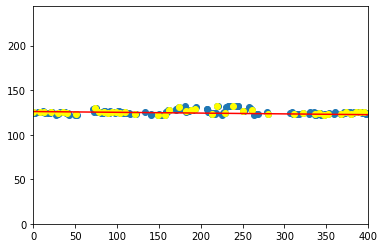

In [88]:
im = Image.open("MVI_0804_VIS_OB_frame298.jpg")
im = im.convert("L")
front = estimar_fronteira(im)
front = iqr_filter(front)
a, b = estimar_modelo_linear(front)
calcular_erro(a, b)

  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.065
w: [-0.007260090137364322, 125.52044232552441]


[[-0.007260090137364322, 125.52044232552441]]

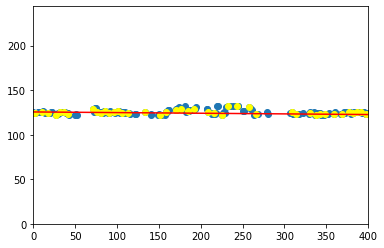

In [87]:
results = []
results.append(estimar_modelo_linear(front))
results

  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.038
w: [-0.04076557511763341, 145.56808473784554]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.051
w: [-0.031395877959394164, 143.1242592981663]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.055
w: [-0.010729152535944843, 137.51324708553662]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.045
w: [-0.00947034668754211, 131.36125691697342]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.042
w: [-0.03269874272154411, 134.53705960087012]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.056
w: [-0.04495462675356661, 129.86982305276481]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.061
w: [0.003751255432224132, 115.96556324535075]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.035
w: [-0.015402005861138934, 116.41862260007971]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.039
w: [-0.037500924185960946, 117.13704110439605]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.033
w: [-0.008980326467093512, 105.78292138167009]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.026
w: [-0.03155935692204121, 107.36675694936156]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.049
w: [-0.010240156029120914, 99.19704173046614]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.042
w: [-0.01776685421312418, 99.1383661362445]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.074
w: [-0.01926812303122736, 95.87224001896922]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.031
w: [-0.03452318136922205, 93.45356603810436]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.051
w: [-0.02108870682035966, 90.4188448385809]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.063
w: [-0.015386876195999556, 88.68840155307808]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.061
w: [-0.01928859011914062, 87.59151665559818]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.031
w: [-0.01623499289186491, 87.98991303940332]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.040
w: [-0.010623943586836389, 85.64385637299189]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.024
w: [-0.031253417397189745, 89.177566976034]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.031
w: [-0.004424826716988961, 85.22345611772953]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.045
w: [-0.025516563147694758, 86.09140879137821]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.031
w: [-0.017182619779914726, 85.84031548939214]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.036
w: [-0.009926438200672577, 85.74863279752206]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.029
w: [-0.046375917017313945, 92.41311554013923]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.052
w: [-0.025777739888036093, 92.61271452348667]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.037
w: [-0.0215117698315346, 95.7073714823132]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.047
w: [-0.01024554669002919, 96.87961427594851]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.031
w: [-0.028112738725596158, 106.44055961146734]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.051
w: [-0.009240238336838425, 108.14279415142853]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.011
w: [0.0030654413016985046, 108.33314144757358]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.034
w: [-0.01341110493089637, 117.56084727530633]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.047
w: [-0.028091270754321305, 123.10046707348454]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.051
w: [-0.02443200989158661, 130.02924557350642]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.035
w: [-0.02026310540134021, 131.52104178037888]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.032
w: [-0.03396745538330404, 137.69324385830947]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.034
w: [-0.03047321524697387, 140.65455688977394]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.033
w: [-0.014233408986074053, 141.85406154490988]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.040
w: [-0.02709308916829229, 148.0365064005986]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.052
w: [-0.02894475697569822, 150.78201642221916]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.065
w: [-0.02923193229338306, 152.648933711725]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.072
w: [-0.02222002065289034, 155.2602657520621]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.031
w: [-0.018231589567297722, 155.69106190048475]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.037
w: [-0.03020745888332983, 161.27744986722175]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.043
w: [-0.01576130158274463, 161.0460613812312]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.026
w: [-0.01860474621714399, 162.18240646126026]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.047
w: [-0.0249183161933459, 165.35433336289276]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.039
w: [-0.013616571861643223, 162.91997620393445]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.000
w: [5.559646529231325e-11, 159.99999998954152]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.000
w: [2.0405046220781012e-07, 158.99994886464975]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.000
w: [4.897061051454736e-05, 162.99143417572273]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.000
w: [1.4646102340438131e-08, 160.99999684216257]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.000
w: [2.59470719253997e-07, 161.99995917491518]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.046
w: [-0.02329240825864445, 163.71272969490843]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.020
w: [-0.017472702994674284, 158.2090489733145]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.000
w: [7.772879738415786e-09, 149.99999806300718]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.033
w: [0.01184044788808261, 144.1825784302944]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.000
w: [1.2041545783896846e-05, 141.9969361117982]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.000
w: [2.074463956467405e-11, 135.9999999954525]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.000
w: [5.620536321188274e-07, 132.99989453745047]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.040
w: [-0.006903273637504004, 129.6310309511489]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.000
w: [3.4606160968268904e-11, 121.99999999112333]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.000
w: [2.573869800865032e-08, 119.99999468263691]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.029
w: [-0.019712809322123475, 118.54925601902774]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.000
w: [0.0003200673032235458, 111.96050655412293]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
found a better model!
model error: 0.035
w: [-0.014803688085236149, 110.73143631624505]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.000
w: [1.077185770312879e-09, 103.9999997392699]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.044
w: [-0.01520610928681387, 102.77697314167114]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.063
w: [-0.004995060968508641, 98.67925942376684]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.036
w: [-0.01980894490479088, 98.87323920290417]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.009
w: [0.0025583914897861606, 89.2633354634405]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.065
w: [-0.08230063014255237, 107.74951908912188]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.061
w: [-0.04423135479933295, 100.12977933187472]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.060
w: [-0.02652011063005514, 94.04884987940144]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.036
w: [-0.031892978762127294, 93.948146187526]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.048
w: [-0.02407092280572154, 91.91574557046849]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.079
w: [-0.04010597816457214, 97.28753112465797]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.049
w: [0.009123813182680648, 84.29734271595385]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.052
w: [-0.025486632695822853, 92.21037711094702]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.054
w: [-0.02632803446931431, 93.26827395422241]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
found a better model!
model error: 0.033
w: [-0.039175380354591005, 98.8561308210945]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.045
w: [-0.05480551440128191, 104.67058876455445]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.073
w: [-0.009955398662892764, 96.44143870263945]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
found a better model!
model error: 0.042
w: [-0.06065440663362494, 114.86972352590608]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.060
w: [-0.04452267597176785, 116.0710982970154]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.030
w: [-0.023839828735869515, 112.02858455897126]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.062
w: [-0.06937721160616969, 125.31180644571457]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.055
w: [-0.0550857827409689, 126.33108064764396]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.043
w: [-0.029928158990172333, 123.95217872968422]


  0%|          | 0/50 [00:00<?, ?it/s]

found a better model!
model error: 0.068
w: [-0.02106462413917019, 123.30401527874541]


  0%|          | 0/50 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'error'

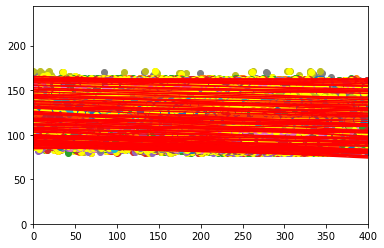

In [34]:
results = []
for i in range(299):
    im = Image.open("../../../../Dataset/VIS_Onboard/VIS_Onboard_frames/MVI_0804_VIS_OB_frame" + str(i) + ".jpg")
    im = im.convert("L")
    front = estimar_fronteira(im)
    front = iqr_filter(front)
    results.append(estimar_modelo_linear(front))